# Un'analisi predittiva sulla serie tv più amata del mondo - I Simpson
## Esame di Programmazione di Applicazioni Data Intensive
#### Laurea in Ingegneria e Scienze Informatiche - A.A. 2019/2020
#### Matteo Castellucci - matteo.castellucci3@studio.unibo.it

### Descrizione del problema e della variabile da predire

Si vogliono analizzare le caratteristiche degli episodi della serie tv "I Simpson" (in originale "The Simpsons") con il fine di predire quanto più accuratamente possibile il [rating su IMDB](https://www.imdb.com/title/tt0096697/) di ciascun episodio. Immaginiamo perciò che tutti gli episodi non siano ancora andati in onda, in modo tale che gli spettatori non abbiano ancora potuto farsene un'opinione, ma che siano già stati prodotti e ne sia stata programmata la trasmissione, in modo tale da sapere il contenuto di ciascuno di essi e il momento in cui saranno trasmessi.

Poichè il valore assoluto del rating di per sè è per noi poco significativo, essendo legato alle esperienze personali degli spettatori, cercheremo di predire una variabile categorica ottenuta da esso che ci dica se l'episodio complessivamente è ritenuto "bello" oppure "brutto" dal pubblico.
Scegliamo le categorie secondo la seguente logica:
- **Bello**: rating superiore a 7,5 incluso
- **Brutto**: rating inferiore a 7,5 escluso  

Dovremo perciò affrontare un problema di classificazione binaria.

### Importazione delle librerie e impostazione delle opzioni

Per prima cosa ci preoccupiamo di importare tutte le librerie, le funzioni e gli oggetti che utilizzeremo. Inoltre, scarichiamo tutti i componenti della libreria NLTK che ci serviranno e impostiamo tutte le proprietà delle librerie utili, in modo da non doverlo fare più avanti. Sopprimiamo inoltre i warning inutili.

In [1]:
%matplotlib inline
import os.path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from scipy.stats import norm
from scipy.sparse import csr_matrix, hstack
from xgboost import XGBClassifier
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv1D, Flatten, Dropout, Reshape
from keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

pd.options.display.max_colwidth = 100
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /home/matteo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/matteo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/matteo/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/matteo/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Importazione del dataset

Verranno utilizzati i dataset contenuti nel post "The Simpsons by the data" originariamente pubblicati da William Kukierski e, data la loro cancellazione da Kaggle, aggiunti nuovamente da Prashant Banerjee. Mi sono riservato di applicare alcune modifiche al dataset originale per renderlo importabile tramite Pandas, visto che presentava alcuni errori di formattazione. Detto questo, lo scarichiamo e lo importiamo.

In [2]:
zip_filename = "the_simpsons.zip"
if not os.path.exists("the_simpsons.zip"):
    from urllib.request import urlretrieve
    urlretrieve("https://drive.google.com/uc?export=download&id=1M4xsnaYl5KfsQ9Wx7wQ9Jc5oBdeCPcTx", zip_filename)
    from zipfile import ZipFile
    with ZipFile(zip_filename) as file:
        file.extractall()

### Comprensione dei dati

Osserviamo per prima cosa i personaggi. Notiamo innanzitutto che ogni riga ha già un suo identificatore dato dalla colonna ``id`` e che, oltre a questa colonna, nel file sono presenti altre tre feature:

- ``name``: il nome del personaggio
- ``normalized_name``: il nome del personaggio costituito da soli caratteri alfabetici minuscoli
- ``gender``: il genere sessuale del personaggio

In [3]:
simpsons_characters = pd.read_csv("simpsons_characters.csv", index_col="id").sort_values("id")
simpsons_characters.iloc[5:15]

,name,normalized_name,gender
id,,,
6,Dewey Largo,dewey largo,m
7,Children,children,NaN
8,Bart Simpson,bart simpson,m
9,Lisa Simpson,lisa simpson,f
10,Patty Bouvier,patty bouvier,f
11,Ned Flanders,ned flanders,m
12,Mechanical Santa,mechanical santa,NaN
13,Tattoo Man,tattoo man,NaN
14,Waylon Smithers,waylon smithers,m


Come si può notare, la stragrande maggioranza dei personaggi non ha genere (perchè è sconosciuto o perché è un insieme di persone) e perciò non è un elemento particolarmente significativo. Questo DataFrame verrà perciò utilizzato solo per identificare il nome dei personaggi, in quanto non riporta altro che tutti i possibili nomi di personaggi presenti nei copioni dei vari episodi, essendo presenti solo nomi unici.

In [4]:
simpsons_characters.describe().loc[["count", "unique"]]

,name,normalized_name,gender
count,6722,6722,323
unique,6722,6722,2


Possiamo perciò già provvedere alla rimozione delle colonne non necessarie.

In [5]:
simpsons_characters.drop(columns=["normalized_name", "gender"], inplace=True)
simpsons_characters.head()

,name
id,
1,Marge Simpson
2,Homer Simpson
3,Seymour Skinner
4,JANEY
5,Todd Flanders


Questo, come vedremo anche per gli altri, è un dataset molto pesante in memoria perchè contiene un numero molto alto di istanze (6722 per la precisione). Per questo, modifichiamo il tipo delle sue colonne in modo da ottimizzare al massimo l'uso della memoria sfruttando i tipi di Pandas. In questo modo, riusciamo a ridurre lo spazio occupato di quasi 5 volte.

In [6]:
simpsons_characters.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6722 entries, 1 to 6749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    6722 non-null   object
dtypes: object(1)
memory usage: 506.4 KB


In [7]:
simpsons_characters = simpsons_characters.astype({
    "name": "string",
})
simpsons_characters.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6722 entries, 1 to 6749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    6722 non-null   string
dtypes: string(1)
memory usage: 105.0 KB


Osservando invece le location notiamo un pattern simile a quello già visto per i personaggi: abbiamo una colonna ``id`` che determina l'identificatore della location, mentre le feature vere e proprie sono:

- ``name``: il nome della location
- ``normalized_name``: il nome della location fatto di soli caratteri alfabetici in minuscolo

In [8]:
simpsons_locations = pd.read_csv("simpsons_locations.csv", index_col="id").sort_values("id")
simpsons_locations.head()

,name,normalized_name
id,,
1,Street,street
2,Car,car
3,Springfield Elementary School,springfield elementary school
4,Auditorium,auditorium
5,Simpson Home,simpson home


Anche in questo caso, il DataFrame è utile solo per poter identificare il nome dei vari luoghi in cui gli episodi si svolgono, contenendo solamente i luoghi unici che compaiono nei vari copioni degli episodi.

In [9]:
simpsons_locations.describe().loc[["count", "unique"]]

,name,normalized_name
count,4459,4459
unique,4459,4459


Possiamo perciò rimuovere ``normalized_name``, non essendoci di alcuna utilità.

In [10]:
simpsons_locations.drop(columns="normalized_name", inplace=True)
simpsons_locations.head()

,name
id,
1,Street
2,Car
3,Springfield Elementary School
4,Auditorium
5,Simpson Home


In questo caso l'uso di memoria incide di meno rispetto al dataset precedente. Decidiamo lo stesso di scegliere i tipi adeguati per le colonne del DataFrame, anche solo per coerenza con il caso precedente, e otteniamo anche in questo caso una diminuzione nell'uso di memoria di un fattore 5.

In [11]:
simpsons_locations.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 1 to 4459
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4459 non-null   object
dtypes: object(1)
memory usage: 356.8 KB


In [12]:
simpsons_locations = simpsons_locations.astype({
    "name": "string",
})
simpsons_locations.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 1 to 4459
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4459 non-null   string
dtypes: string(1)
memory usage: 69.7 KB


Questo dataset invece è quello che contiene i dati relativi ai singoli episodi. In esso troviamo un identificatore per ciascun episodio contraddistinto dal nome ``id``, come nei precedenti dataset, mentre le altre sue feature sono:

- ``image_url``: l'URL del frame che rappresenta l'episodio
- ``imdb_rating``: il rating che l'episodio ha su IMDB
- ``imdb_votes``: il numero di voti che hanno contribuito al rating su IMDB
- ``number_in_season``: il numero dell'episodio all'interno della stagione
- ``number_in_series``: il numero dell'episodio all'interno dell'intera serie
- ``original_air_date``: la data della prima trasmissione originale dell'episodio
- ``original_air_year``: l'anno della prima trasmissione originale dell'episodio
- ``production_code``: il codice di produzione dell'episodio
- ``season``: il numero della stagione dell'episodio
- ``title``: il titolo dell'episodio
- ``us_viewers_in_millions``: il numero di spettatori per quell'episodio in milioni
- ``video_url``: l'URL per vedere l'episodio sul sito di Fox
- ``views``: il numero di visualizzazioni dell'episodio sul sito di Fox

In [13]:
simpsons_episodes = pd.read_csv("simpsons_episodes.csv", index_col="id").sort_values("id")
simpsons_episodes.head()

,image_url,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,title,us_viewers_in_millions,video_url,views
id,,,,,,,,,,,,,
1,http://static-media.fxx.com/img/FX_Networks_-_FXX/617/479/Simpsons_01_08.jpg,8.2,3734.0,1,1,1989-12-17,1989,7G08,1,Simpsons Roasting on an Open Fire,26.7,http://www.simpsonsworld.com/video/273376835817,171408.0
2,http://static-media.fxx.com/img/FX_Networks_-_FXX/265/167/Simpsons_01_02.jpg,7.8,1973.0,2,2,1990-01-14,1990,7G02,1,Bart the Genius,24.5,http://www.simpsonsworld.com/video/283744835990,91423.0
3,http://static-media.fxx.com/img/FX_Networks_-_FXX/621/883/Simpsons_01_03.jpg,7.5,1709.0,3,3,1990-01-21,1990,7G03,1,Homer's Odyssey,27.5,http://www.simpsonsworld.com/video/273381443699,78072.0
4,http://static-media.fxx.com/img/FX_Networks_-_FXX/632/119/Simpsons_01_04__343617.jpg,7.8,1701.0,4,4,1990-01-28,1990,7G04,1,There's No Disgrace Like Home,20.2,http://www.simpsonsworld.com/video/273392195780,67378.0
5,http://static-media.fxx.com/img/FX_Networks_-_FXX/274/735/Simpsons_01_05.jpg,8.1,1732.0,5,5,1990-02-04,1990,7G05,1,Bart the General,27.1,http://www.simpsonsworld.com/video/300934723994,63129.0


Colonne come ``image_url`` e ``video_url`` non sono di alcuna utilità, così come quelle per identificare l'episodio, ``number_in_season``, ``number_in_series``, ``production_code``, avendo già un identificatore. Le feature ``imdb_votes``, ``us_viewers_in_millions`` e ``views`` non sono note in anticipo per come abbiamo descritto il problema e ``original_air_year`` è una feature duplicata. Per tutte queste ragioni, le colonne descritte verranno eliminate dal DataFrame.

In [14]:
simpsons_episodes.drop(columns=simpsons_episodes.columns.difference(["imdb_rating", "original_air_date", "season", "title"]), inplace=True)
simpsons_episodes.head()

,imdb_rating,original_air_date,season,title
id,,,,
1,8.2,1989-12-17,1,Simpsons Roasting on an Open Fire
2,7.8,1990-01-14,1,Bart the Genius
3,7.5,1990-01-21,1,Homer's Odyssey
4,7.8,1990-01-28,1,There's No Disgrace Like Home
5,8.1,1990-02-04,1,Bart the General


In questo caso l'uso di memoria è insignificante, ma per poter essere compatibile con i precedenti dataset dobbiamo trasformarlo con i tipi di dato adeguati, che inevitabilmente ci farà risparmiare non poca memoria.

In [15]:
simpsons_episodes.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 1 to 600
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   imdb_rating        597 non-null    float64
 1   original_air_date  600 non-null    object 
 2   season             600 non-null    int64  
 3   title              600 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 99.0 KB


In [16]:
simpsons_episodes = simpsons_episodes.astype({
    "title": "string"
})
simpsons_episodes["original_air_date"] = pd.to_datetime(simpsons_episodes["original_air_date"])
simpsons_episodes.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 1 to 600
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   imdb_rating        597 non-null    float64       
 1   original_air_date  600 non-null    datetime64[ns]
 2   season             600 non-null    int64         
 3   title              600 non-null    string        
dtypes: datetime64[ns](1), float64(1), int64(1), string(1)
memory usage: 23.4 KB


In quest'utlimo dataset sono invece contenute tutte le battute dei copioni dei vari episodi. Oltre alla colonna ``id`` che fa da identificatore, vista più volte, troviamo:
- ``episode_id``: l'identificatore dell'episodio, utile per effettuare join con il DataFrame che contiene gli episodi
- ``number``: il numero della battuta all'interno del copione dell'episodio
- ``raw_text``: il testo della battuta così com'è stato trovato nel copione
- ``timestamp_in_ms``: il timestamp dell'istante in cui la battuta viene pronunciata all'interno dell'episodio
- ``speaking_line``: se la battuta viene pronunciata da qualcuno o semplicemente è un appunto dello sceneggiatore
- ``character_id``: l'identificatore del personaggio che pronuncia la battuta
- ``location_id``: l'identificatore della location in cui viene pronunciata la battuta
- ``raw_character_text``: il nome del personaggio che pronuncia la battuta
- ``raw_location_text``: il nome del luogo in cui la battuta viene pronunciata
- ``spoken_words``: il testo della battuta con rimossi i suggerimenti di interpretazione e il nome di chi la pronuncia
- ``normalized_text``: come ``spoken_words`` ma sono stati rimossi tutti i caratteri non alfabetici e quelli rimasti posti in minuscolo
- ``word_count``: il conteggio delle parole nella battuta

In [17]:
simpsons_script_lines = pd.read_csv("simpsons_script_lines.csv", index_col="id").sort_values("id")
simpsons_script_lines.iloc[5:10]

,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
id,,,,,,,,,,,,
6,1,5,(Springfield Elementary School: Ext. springfield elementary school - establishing - night),24000.0,False,NaN,3.0,NaN,Springfield Elementary School,NaN,NaN,NaN
7,1,6,(Auditorium: int. auditorium - night),24000.0,False,NaN,4.0,NaN,Auditorium,NaN,NaN,NaN
8,1,7,"Marge Simpson: (HUSHED VOICE) Sorry, Excuse us. Pardon me...",24000.0,True,1.0,4.0,Marge Simpson,Auditorium,"Sorry, Excuse us. Pardon me...",sorry excuse us pardon me,5.0
9,1,8,"Homer Simpson: (SIMULTANEOUSLY) Hey, Norman. How's it going? So you got dragged down here, too.....",26000.0,True,2.0,4.0,Homer Simpson,Auditorium,"Hey, Norman. How's it going? So you got dragged down here, too... heh, heh. How ya doing, Fred? ...",hey norman hows it going so you got dragged down here too heh heh how ya doing fred excuse me fred,21.0
10,1,9,Homer Simpson: Pardon my galoshes. (CHUCKLES),34000.0,True,2.0,4.0,Homer Simpson,Auditorium,Pardon my galoshes.,pardon my galoshes,3.0


La colonna ``raw_text``, benchè possa sembrare utile, in realtà può essere eliminata, perchè sono le colonne successive a mantenere i suoi dati utili in una forma più leggibile. L'unico caso in cui si perdono delle informazioni si ha quando la battuta non è pronunciata e perciò indica un cambio di location o uno specifico momento del giorno. Il luogo indicato però è presente alla feature ``location_id`` e ``raw_location_text``, mentre il momento del giorno non è un'informazione particolarmente significativa. Inoltre, ``spoken_words`` è migliore di ``raw_text`` perchè non presenta i suggerimenti di interpretazione, che non fanno capire che cosa sta succedendo durante quella battuta, e perchè chi la pronuncia è già inserito nelle colonne ``character_id`` e ``raw_character_text``. Tratterremo però ``raw_text`` al momento perchè ci servirà per l'elaborazione dei dati succssiva. La feature ``speaking_line`` non è necessaria da trattenere poichè tutte le righe che hanno la colonna ``spoken_words`` diversa da NA hanno anche ``speaking_line`` posto a True, rendendolo un attributo derivato al pari di ``normalized_text``, ``word_count``, ``raw_character_text`` e ``raw_location_text``. Possiamo perciò eliminare queste colonne tranquillamente. La feature ``timestamp_in_ms`` non ci dà alcuna informazione utile.

In [18]:
simpsons_script_lines[(simpsons_script_lines["speaking_line"] == True) & (simpsons_script_lines["spoken_words"].isna())].size

0

In [19]:
simpsons_script_lines.drop(columns=simpsons_script_lines.columns.difference(["episode_id", "number", "raw_text", "character_id", "location_id", "spoken_words"]), inplace=True)
simpsons_script_lines.head()

,episode_id,number,raw_text,character_id,location_id,spoken_words
id,,,,,,
1,1,0,(Street: ext. street - establishing - night),NaN,1.0,NaN
2,1,1,(Car: int. car - night),NaN,2.0,NaN
3,1,2,"Marge Simpson: Ooo, careful, Homer.",1.0,2.0,"Ooo, careful, Homer."
4,1,3,Homer Simpson: There's no time to be careful.,2.0,2.0,There's no time to be careful.
5,1,4,Homer Simpson: We're late.,2.0,2.0,We're late.


Per quest'ultimo DataFrame l'uso della memoria è importantissimo, dato che occupa oltre 20 MiB. Anche in questo caso ci affidiamo all'assegnamento dei tipi di dato di Pandas per migliorare l'uso della memoria, che migliora in questo caso solo di un fattore 2.

In [20]:
simpsons_script_lines.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158301 entries, 1 to 158315
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   episode_id    158301 non-null  int64  
 1   number        158301 non-null  int64  
 2   raw_text      158301 non-null  object 
 3   character_id  140760 non-null  float64
 4   location_id   157878 non-null  float64
 5   spoken_words  132139 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 39.7 MB


In [21]:
simpsons_script_lines = simpsons_script_lines.astype({
    "character_id": pd.Int64Dtype(),
    "location_id": pd.Int64Dtype(),
    "spoken_words": "string"
})
simpsons_script_lines.head()

,episode_id,number,raw_text,character_id,location_id,spoken_words
id,,,,,,
1,1,0,(Street: ext. street - establishing - night),<NA>,1,<NA>
2,1,1,(Car: int. car - night),<NA>,2,<NA>
3,1,2,"Marge Simpson: Ooo, careful, Homer.",1,2,"Ooo, careful, Homer."
4,1,3,Homer Simpson: There's no time to be careful.,2,2,There's no time to be careful.
5,1,4,Homer Simpson: We're late.,2,2,We're late.


In [22]:
simpsons_script_lines.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158301 entries, 1 to 158315
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   episode_id    158301 non-null  int64 
 1   number        158301 non-null  int64 
 2   raw_text      158301 non-null  object
 3   character_id  140760 non-null  Int64 
 4   location_id   157878 non-null  Int64 
 5   spoken_words  132139 non-null  string
dtypes: Int64(2), int64(2), object(1), string(1)
memory usage: 26.5 MB


### Analisi dei dati

Gli episodi contenuti nel dataset sono 600, ma solo i primi 597 hanno un rating su IMDB. Questo è segno del fatto che quando questi dati sono stati raccolti quegli episodi erano ancora molto recenti e non c'erano sufficienti valutazioni per estrarre un rating.

In [23]:
simpsons_episodes.describe()

,imdb_rating,season
count,597.000000,600.000000
mean,7.386097,14.100000
std,0.732439,7.755444
min,4.500000,1.000000
25%,6.900000,7.000000
50%,7.300000,14.000000
75%,8.000000,21.000000
max,9.200000,28.000000


In [24]:
simpsons_episodes[simpsons_episodes["imdb_rating"].isna()].equals(simpsons_episodes.tail(3))

True

Sui 597 episodi, in media le recensioni li hanno considerati nella media, cioè tra il "bello" e il "brutto", con un valore però che tende maggiormente verso il "brutto", seguendo le classi che abbiamo definito all'inizio. Questo vuol dire che il punto di separazione tra i valori inclusi tra le due classi è corretto, nell'ottica di avere due classi bilanciate. La mediana non si discosta molto dal valore medio, segno che le recensioni sono state molto equilibrate, senza troppi valori estremi, come ci conferma anche il boxplot. Esistono però due episodi, considerati i peggiori della serie, che sono *outliers* rispetto alla distribuzione di tutti i voti.

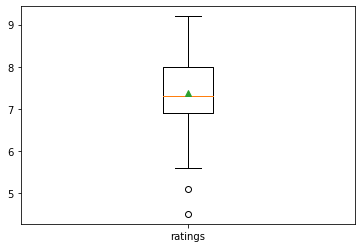

In [25]:
plt.boxplot(simpsons_episodes["imdb_rating"].dropna(), showmeans=True, labels=["ratings"]);

In [26]:
simpsons_episodes.sort_values("imdb_rating").head(2)[["title", "imdb_rating"]]

,title,imdb_rating
id,,
508,Lisa Goes Gaga,4.5
189,"All Singing, All Dancing",5.1


Osservando l'istogramma, si nota come la distribuzione dei valori si avvicini sufficientemente a quella di una gaussiana, fatto testimoniato anche dalla deviazione standard che ha un valore prossimo a 1 (0,73). Possiamo considerare le recensioni come ben distribuite.

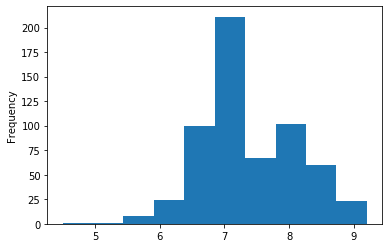

In [27]:
simpsons_episodes["imdb_rating"].plot.hist();

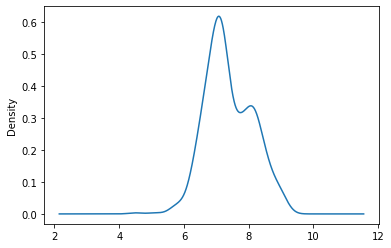

In [28]:
simpsons_episodes["imdb_rating"].plot.density();

Il dataset considera gli episodi de "I Simpson" delle prime 28 stagioni, e nell'ultima non tiene in considerazione tutti gli episodi, ma solamente i primi quattro, fatto facilmente verificabile consultando la [pagina di Wikipedia](https://it.wikipedia.org/wiki/Episodi_de_I_Simpson_(ventottesima_stagione)) che riguarda quella stagione.

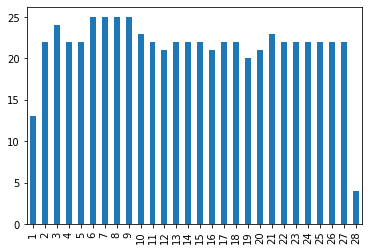

In [29]:
simpsons_episodes["season"].value_counts().sort_index().plot.bar();

Ogni nuovo episodio è andato in onda quasi esclusivamente di domenica, fatta eccezione per un centinaio di episodi, andati in onda di giovedì, e poi in maniera insignificante alcuni altri nuovi episodi sono andati in onda nei restanti giorni della settimana. Questo ci dice che questa possibile feature ha scarsa variabilità e non è utile ternerne conto durante la classificazione

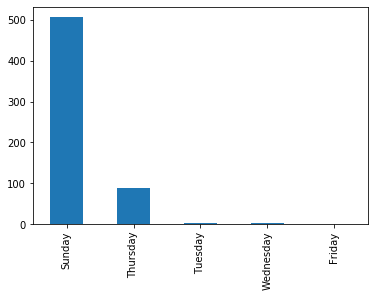

In [30]:
simpsons_episodes.original_air_date.dt.day_name().value_counts().plot.bar();

I nuovi episodi sono andati in onda durante tutto l'anno con all'incirca sempre la stessa frequenza, ad eccezione del periodo esitvo. Questi dati non ci sorprendono però, dato che la stagione televisiva si svolge da settembre a maggio. Quindi anche questo dato non è particolarmente significativo, non indica alcuna particolarità espressa dalla serie tv.

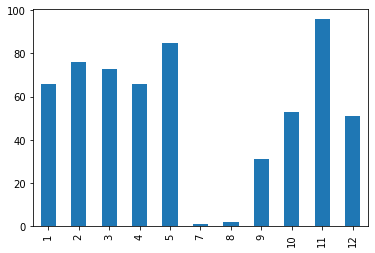

In [31]:
simpsons_episodes.original_air_date.dt.month.value_counts().sort_index().plot.bar();

Un'altra particolarità che notiamo è un fatto di cui tutti gli appassionati della serie sono convinti: le prime stagioni sono considerate mediamente più belle di quelle successive. Dal grafico a barre si nota infatti che per le stagioni dalla 2 alla 8 il punteggio medio è pari o superiore a 8 (episodi "belli" o "molto belli"), mentre per le stagioni successive la media si attesta attorno a 7 ("nella media") o meno.

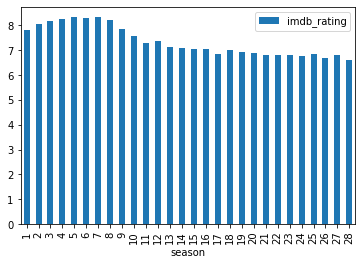

In [32]:
simpsons_episodes.groupby("season").mean().plot.bar();

Mediamente, nel copione di ogni episodio vengono inserite 281 battute di cui 234 vengono pronunciate da un attore.

In [33]:
simpsons_script_lines.groupby("episode_id")[["raw_text", "spoken_words"]].count().mean()

raw_text        280.675532
spoken_words    234.289007
dtype: float64

Come si può osservare, il numero di battute tra tutti i copioni che vengono pronunciate è inferiore (26.000 istanze) a quello delle battute in generale nei copioni. Questo per noi non rappresenta un problema, ciò che invece potrebbe rappresentare un problema sono quelle battute dove non è dato il personaggio che le pronuncia, dato che non può essere sconosciuto. Discorso diverso vale per i luoghi, infatti è possibile che la battuta sia pronunciata in un luogo che si ignora, perchè magari non viene mostrato. Si nota infatti che le battute pronunciate senza personaggio sono pochissime, segno di una mancanza di dati dovuta a degli errori, mentre invece le battute senza un luogo specificato sono molte di più, anche se sempre molto poche in confronto a quelle dell'intero dataset.

In [34]:
simpsons_script_lines[["raw_text", "spoken_words"]].count()

raw_text        158301
spoken_words    132139
dtype: int64

In [35]:
simpsons_script_lines[~simpsons_script_lines["spoken_words"].isna() & simpsons_script_lines["character_id"].isna()].head()

,episode_id,number,raw_text,character_id,location_id,spoken_words
id,,,,,,
4213,14,205,Martin Prince: Who would have thought that pushing a boy into the girls' lavatory could be such ...,<NA>,<NA>,Who would have thought that pushing a boy into the girls' lavatory could be such a thrill? The s...
4262,14,254,"Entire Town: A BEAUTIFUL SIGHT / WE'RE HAPPY TONIGHT/ WALKIN' IN A WINTER WONDERLAND."" /",<NA>,<NA>,A BEAUTIFUL SIGHT / WE'RE HAPPY TONIGHT/ WALKIN' IN A WINTER WONDERLAND. /
4266,14,258,"Bart Simpson: (READING ALOUD, WITH HEART) Chapter Six: Four Days in Philadelphia. The first Cont...",<NA>,<NA>,Chapter Six: Four Days in Philadelphia. The first Continental Congress faced a difficult job. Co...
5346,18,200,Tony Bennett: CALLED CAPITAL CITY...,<NA>,<NA>,CALLED CAPITAL CITY...
5349,18,203,Tony Bennett: IN CAPITAL CITY...,<NA>,<NA>,IN CAPITAL CITY...


In [36]:
simpsons_script_lines[~simpsons_script_lines["spoken_words"].isna() & simpsons_script_lines["location_id"].isna()].head()

,episode_id,number,raw_text,character_id,location_id,spoken_words
id,,,,,,
4213,14,205,Martin Prince: Who would have thought that pushing a boy into the girls' lavatory could be such ...,<NA>,<NA>,Who would have thought that pushing a boy into the girls' lavatory could be such a thrill? The s...
4262,14,254,"Entire Town: A BEAUTIFUL SIGHT / WE'RE HAPPY TONIGHT/ WALKIN' IN A WINTER WONDERLAND."" /",<NA>,<NA>,A BEAUTIFUL SIGHT / WE'RE HAPPY TONIGHT/ WALKIN' IN A WINTER WONDERLAND. /
4266,14,258,"Bart Simpson: (READING ALOUD, WITH HEART) Chapter Six: Four Days in Philadelphia. The first Cont...",<NA>,<NA>,Chapter Six: Four Days in Philadelphia. The first Continental Congress faced a difficult job. Co...
4588,16,0,"Marge Simpson: (CLEARING HER THROAT) Hello, everyone. (CLEARING HER THROAT) You know, Halloween ...",1,<NA>,"Hello, everyone. You know, Halloween is a very strange holiday. Personally, I don't understand i..."
5346,18,200,Tony Bennett: CALLED CAPITAL CITY...,<NA>,<NA>,CALLED CAPITAL CITY...


È possibile osservare che in media all'interno di ciascun episodio della serie della serie i personaggi che compaiono hanno sei battute a testa, anche se questo dato è fortemente sbilanciato: ad esempio la metà dei personaggi a livello di singolo episodio ha una o due battute al massimo e ci sono personaggi che in un singolo episodio pronunciano fino a 131 battute. Questo significa che pochi personaggi sono veramente rilevanti nella serie tv.

In [37]:
lines = pd.DataFrame(simpsons_script_lines.dropna(axis="index", subset=["spoken_words"]) \
                                  .groupby(["episode_id", "character_id"]) \
                                  .size(), columns=["size"])
lines.describe()

,size
count,19995.000000
mean,6.607702
std,12.653093
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,131.000000


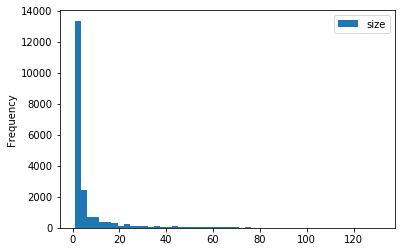

In [38]:
lines.plot.hist(bins=50);

Discorso analogo si può fare per le location, in media ciascuna location a livello di singolo episodio compare 13 volte nel copione, però un quarto delle location non compare mai più di tre volte ed esistono location che compaiono fino a 203 volte. Quindi, poche location nella serie sono veramente importanti per caratterizzare un episodio.

In [39]:
locations = pd.DataFrame(simpsons_script_lines.dropna(axis="index", subset=["spoken_words"]) \
                                              .groupby(["episode_id", "location_id"]) \
                                              .size(), columns=["size"])
locations.describe()

,size
count,10041.000000
mean,13.120805
std,18.007592
min,1.000000
25%,3.000000
50%,7.000000
75%,15.000000
max,203.000000


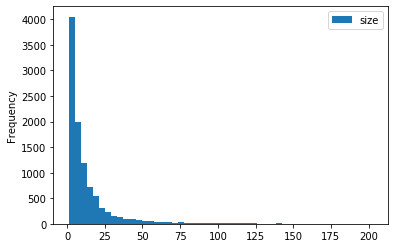

In [40]:
locations.plot.hist(bins=50);

### Rimozione dei valori mancati e preparazione dei dati

Sulla base di quanto detto, possiamo rimuovere ``original_air_date`` e ``season`` dal DataFrame sugli episodi perchè le feature che potremmo estrarre hanno una scarsa variabilità o comunque presentano delle tendenze che vorremmo non influenzassero la nostra classificazione. Inoltre, possiamo rimuovere ``title`` perchè non ci serve più.

In [41]:
simpsons_episodes.drop(columns=["original_air_date", "title", "season"], inplace=True)
simpsons_episodes.shape

(600, 1)

A questo punto, cerchiamo di sostituire i valori NA di ``character_id`` con quelli corretti quando anche ``spoken_words`` è diverso da NA utilizzando le peculiarità di ``raw_text``. Infatti, generalmente le battute pronunciate nella colonna ``raw_text`` sono precedute dal nome di chi le pronuncia, seguito dai due punti.

In [42]:
missing = simpsons_script_lines[(~simpsons_script_lines["spoken_words"].isna()) & (simpsons_script_lines["character_id"].isna())]
for index, row in missing.iterrows():
    name = row["raw_text"].split(":")[0]
    if name != "":
        simpsons_script_lines.loc[index, "character_id"] = simpsons_characters[simpsons_characters["name"] == name].index

Fatto questo, ``raw_text`` non ci serve più e può essere eliminato.

In [43]:
simpsons_script_lines.drop(columns="raw_text", inplace=True)
simpsons_script_lines.dropna(axis="index", subset=["spoken_words"], inplace=True)
simpsons_script_lines.head()

,episode_id,number,character_id,location_id,spoken_words
id,,,,,
3,1,2,1,2,"Ooo, careful, Homer."
4,1,3,2,2,There's no time to be careful.
5,1,4,2,2,We're late.
8,1,7,1,4,"Sorry, Excuse us. Pardon me..."
9,1,8,2,4,"Hey, Norman. How's it going? So you got dragged down here, too... heh, heh. How ya doing, Fred? ..."


### Selezione delle feature rilevanti

A questo punto, abbiamo ripulito i nostri DataFrame in modo che potessero essere rielaborati per poter estrarre la variabile da predire e le feature di nostro interesse. Possiamo procedere dunque con l'unione delle singole battute dei copioni per ottenere nuovamente i copioni originali di ciascun episodio e successivamente effettuare un join con il primo DataFrame per associare a ciascun episodio il suo rating su IMDB.

In [44]:
scripts = pd.DataFrame()
simpsons_script_lines.sort_values(["episode_id", "number"], inplace=True)
scripts["spoken_words"] = simpsons_script_lines.groupby("episode_id")["spoken_words"].apply(' '.join)
episodes = simpsons_episodes.join(scripts)
episodes = episodes.astype({
    "spoken_words": "string"
})
episodes.head()

,imdb_rating,spoken_words
id,,
1,8.2,"Ooo, careful, Homer. There's no time to be careful. We're late. Sorry, Excuse us. Pardon me... H..."
2,7.8,"Come on, Mom. Yeah, Mom, hurry up. All right... hmmm... How about ""he""? Two points. Your turn, d..."
3,7.5,"Now, class, I don't want this field trip to be a repeat of our infamous visit to the Springfield..."
4,7.8,"Oh, yeah? Yeah! Oh, yeah? Yeah! Oh, yeah? Yeah! Oh, yeah? Yeah! Hey! What's the problem here? We..."
5,8.1,"Do I smell cupcakes? Oooo, Do I ever! Uh-uh, Homer. Lisa's making these for her teacher. Ah. Say..."


Come si può notare, ci sono 597 episodi con rating su IMDB, mentre quelli di cui era presente il copione erano solo 564. Non è possibile effetuare la classificazione se il rating IMDB è assente e non è molto utile tentare di farlo se il copione non è presente e non abbiamo modo di sapere cosa conteneva, perciò, eliminiamo tutte le righe che presentano valori NA, consapevoli che ci rimangono molte istanze da sfruttare.

In [45]:
episodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 1 to 600
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   imdb_rating   597 non-null    float64
 1   spoken_words  564 non-null    string 
dtypes: float64(1), string(1)
memory usage: 14.1 KB


In [46]:
episodes.dropna(inplace=True)

Cerchiamo quindi di costruire delle altre feature rilevanti che possiamo estrarre da ``simpsons_script_lines``. Possiamo ad esempio associare a ciascun episodio il numero di volte che ciascun personaggio pronuncia una battuta. Poichè i personaggi sono molti, salviamo questi dati in una matrice sparsa e, poichè sappiamo che a livello di singolo episodio un personaggio non pronuncia mai più di 131 battute, possiamo scegliere un tipo di dato più adeguato per salvare questi valori per risparmiare spazio in memoria.

In [47]:
characters = simpsons_script_lines.drop(columns=["number", "location_id", "spoken_words"]) \
                                  .dropna() \
                                  .join(simpsons_characters, on="character_id") \
                                  .drop(columns="character_id") \
                                  .groupby(["episode_id", "name"]) \
                                  .size() \
                                  .unstack() \
                                  .fillna(0) \
                                  .astype(np.int8) \
                                  .reindex(episodes.index)
characters_cols = characters.columns
characters = csr_matrix(characters)

Possiamo ripetere lo stesso procedimento per le location, associando a ciascun episodio il numero di volte che una battuta è pronunciata in una determinata location, per ciascuna location. Poichè le location sono molte, salviamo anche questi dati in una matrice sparsa. Inoltre, sappiamo che a livello di singolo episodio in una data location non sono mai pronunciate più di 203 battute, perciò possiamo scegliere un tipo di dato più adeguato per salvare questi valori e risparmiare così memoria.

In [48]:
locations = simpsons_script_lines.drop(columns=["number", "character_id", "spoken_words"]) \
                                 .dropna() \
                                 .join(simpsons_locations, on="location_id") \
                                 .drop(columns="location_id") \
                                 .groupby(["episode_id", "name"]) \
                                 .size() \
                                 .unstack() \
                                 .fillna(0) \
                                 .astype(np.int8) \
                                 .reindex(episodes.index)
locations_cols = locations.columns
locations = csr_matrix(locations)

Fatto questo, possiamo anche sbarazzarci di ``simpsons_episodes`` e ``simpsons_script_lines``, perchè abbiamo estratto tutto ciò che potevamo.

In [49]:
del simpsons_episodes
del simpsons_script_lines

Aggiungiamo quindi la variabile categorica da predire.

In [50]:
episodes["label"] = np.where(episodes["imdb_rating"] >= 7.5, "good", "bad")
episodes.drop(columns="imdb_rating", inplace=True)
episodes = episodes.astype({"label": "string"})
episodes.iloc[5:10]

,spoken_words,label
id,,
6,"Lisa! Lisa, are you still in there? What's the problem? Did you fall in? Lisa! Sorry, Dad. Women...",good
7,"Rusty old hunk of junk. Howdy, Bart. Hot enough for ya? Shut up, Flanders. Hey dad, how come we ...",good
8,"You know, Bart, when I was your age, I pulled a few boners, but I think you'll find that people ...",good
9,"Whoops! Whoops! Oh, whoops... whoops! This is gonna be the best birthday breakfast Mom ever had....",good
10,"So how was the office birthday party? Oh, it was delightful. The frosting on the cake was this t...",bad


Il diagramma a torta ci mostra come le deduzioni fatte sulle distribuzioni dei rating fatte in precedenza si applichino correttamente. Infatti, le due classi sono legermente sbilanciate, si trovano infatti in un rapporto 60-40, verso il "brutto". Non ci preoccuperemo perciò di bilanciare le istanze tra le due classi, essendo molto vicine al perfetto bilanciamento, però terremo conto di questa proporzione quando effettueremo il calcolo dell'accuratezza nei modelli classificazione. Infatti, sarà molto più facile produrre un modello corretto se tende a classificare tutti gli episodi come "brutto" rispetto ad uno che li classifica tutti come "bello".

In [51]:
episodes["label"].value_counts()

bad     325
good    239
Name: label, dtype: Int64

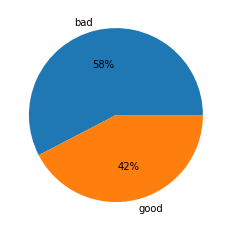

In [52]:
fig, _ = plt.subplots()
plt.pie(episodes["label"].value_counts(), labels=["bad", "good"], autopct="%1.0f%%")
fig.set_facecolor("white")

### Estrazione delle feature testuali

A questo punto cerchiamo di estrarre le feature testuali, ovverosia le parole o parti di esse, più rilevanti dai copioni precedentemente ricostruiti. Prima di tutto dobbiamo ottenere i nostri train e validation set sia a partire dai copioni originali sia dalle classi dei rating, poi dobbiamo costruire i *fold* per la *cross-validation*.

In [53]:
X = episodes["spoken_words"]
y = episodes["label"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=742)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=742)

#### Scelta del tokenizer

Per prima cosa cerchiamo di trovare il miglior *tokenizer* da applicare sui copioni. Per questo motivo al momento non ci preoccupiamo dell'indice di importanza delle parole, scegliamo di default il *tf-idf index* che risulta più veloce su questo dataset. Detto questo, analizziamo il "caso base" del *vectorizer* e cerchiamo di ridurre via via il numero di feature senza mai compromettere in maniera significativa l'accuratezza del modello preso in esame.

In [54]:
vectorizer_base = TfidfVectorizer()
vectorizer_base.fit_transform(X_train)
features = vectorizer_base.get_feature_names()
features[0:5], features[327:332], features[350:355], features[370:375], features[-5:]

(['00', '000', '007', '07s', '10'],
 ['_______', 'a647253', 'aa', 'aaaa', 'aaaaa'],
 ['aaannnd', 'aaannnnd', 'aaanyway', 'aag', 'aagh'],
 ['abbie', 'abbotan', 'abbots', 'abbreviate', 'abbreviations'],
 ['éclairios', 'êtes', 'être', 'ĉu', 'ĝi'])

Senza applicare nulla, otteniamo 32.933 features, ovvero 32.933 parole, molte delle quali osserviamo essere numeri oppure storpiature di parole inserite solo per rendere meglio l'interpretazione delle frasi. Ha perciò senso provare un metodo di *tokenization* differente per osservare se le feature che estrae sono più significative.

In [55]:
len(features)

32993

Testiamo allora il *tokenizer* del modulo NLTK.

In [56]:
vectorizer_tokenizer = TfidfVectorizer(tokenizer=nltk.word_tokenize)
vectorizer_tokenizer.fit_transform(X_train)
features = vectorizer_tokenizer.get_feature_names()
features[0:5], features[30:35], features[350:355], features[370:375], features[-5:]

(['!', '#', '$', '%', '&'],
 ["'allo", "'angry", "'appen", "'applause", "'at"],
 ['1977', '1977.', '1979', '1979.', '1980'],
 ['19:19', '19:19.', '19th', '1:00', '1:30'],
 ['é', 'éclairios', 'êtes', 'ĉu', 'ĝi'])

L'uso del *tokenizer* di NLTK ha generato all'incirca 5.000 feature in più, anche se notiamo che in questo caso le feature sembrano essere generate con più criterio. Compaiono dei simboli di punteggiatura che prima non avevamo incontrato, che ha senso che vengano considerati in maniera a sè stante, dato che non fanno parte di alcuna parola, e non troviamo più numeri dall'aspetto casuale. Notiamo che sono state aggiunte molte parole apostrofate che il *tokenizer* standard non aveva saputo riconoscere.

In [57]:
len(features)

37661

Proviamo a questo punto a rimuovere gli accenti e a rimuovere le *stop words*, per cercare di trattenere tutte e sole quelle parole che identificano con chiarezza di cosa si sta parlando, eliminando perciò le parole di contorno. Proviamo inoltre a rimuovere la punteggiatura, ovvero sia tutti quei token che non contengono neanche una lettera o un numero.

In [58]:
def tokenize_with_nltk(text):
    return [token for token in nltk.word_tokenize(text) if re.match(r"[a-zA-Z0-9]+", token) is not None]

In [59]:
nltk_stoplist = nltk.corpus.stopwords.words("english")
stoplist = list(set([token for word in nltk_stoplist for token in tokenize_with_nltk(word)]))

In [60]:
vectorizer_stopwords = TfidfVectorizer(tokenizer=tokenize_with_nltk, stop_words=stoplist, strip_accents="unicode")
vectorizer_stopwords.fit_transform(X_train)
features = vectorizer_stopwords.get_feature_names()
features[0:5], features[30:35], features[350:355], features[370:375], features[-5:]

(['0', '0.', '007', '1', '1,000'],
 ['10th', '11', '111238,390,17', '1132.', '117th'],
 ['60', '600', '6000', '605', '6051'],
 ['69808,243,293', '6:45', '6th', '7', '7-10'],
 ['zz', 'zz-99', 'zzyzwiski', 'zzzapp', 'zzzzapp'])

La rimozione dei token descritti in precedenza non ha giovato particolarmente. Sono state rimosse solamente 400 feature, all'incirca. Evidentemente il metodo usato finora non è stato capace di cogliere tutti quegli elementi che aveva senso rimuovere.

In [61]:
len(features)

37257

#### Applicazione di meccanismi avanzati: POS tagging, lemmatization, stemming

Proviamo a questo punto a complicare la *tokenization* applicandole i meccanismi di *POS tagging*, di lemmatizzazione e di *stemming*, cercando di ridurre ancora il numero delle feature togliendo tutte quelle parole che non sono altro che la variante della stessa dove però cambia la declinazione grammaticale, che non va ad incidere particolarmente sul contenuto generale del discorso.

In [62]:
def tokenize_with_pos(text):
    return nltk.pos_tag(tokenize_with_nltk(text))

In [63]:
pos_stoplist = list(set([token for word in nltk_stoplist for token in tokenize_with_pos(word)]))

In [64]:
wnl = nltk.stem.WordNetLemmatizer()
penn_to_wn = {"N": "n", "V": "v", "J": "a", "R": "r"}
def tokenize_with_lemmatization(text):
    return [(wnl.lemmatize(token, penn_to_wn[tag[0]]) if tag[0] in penn_to_wn else token) for token, tag in tokenize_with_pos(text)]

In [65]:
lemmatization_stoplist = list(set([token for word in nltk_stoplist for token in tokenize_with_lemmatization(word)]))

In [66]:
ps = nltk.stem.PorterStemmer()
def tokenize_with_stemming(text):
    return [ps.stem(word) for word in tokenize_with_nltk(text)]

In [67]:
stemming_stoplist = list(set([token for word in nltk_stoplist for token in tokenize_with_stemming(word)]))

Questa volta, avendo a disposizione un range di valori tra cui scegliere, sceglieremo il *tokenizer* effettuando delle regressioni logistiche di prova. Introduciamo  la standardizzazione delle feature visto che il conteggio delle parole è un indice non normalizzato. Notiamo come l'uso del *POS tagging* aumenta il numero delle feature perchè introduce varianti della stessa parola con però associati diversi tag, dato che una stessa parola può ricoprire più ruoli all'interno del discorso. Il risultato è che però l'accuratezza scende, come potevamo aspettarci, anche se non in maniera significativa. La lemmatizzazione invece riesce a ridurre il numero di feature con un aumento dell'accuratezza, ma il metodo migliore si rivela lo stemming. Esso infatti riduce più di tutti gli altri il numero delle feature, facendo di contro salire l'accuratezza il più possibile. Useremo perciò quest'ultimo metodo nel prosieguo dell'eliminazione delle feature non rilevanti.

In [68]:
results = []
values = [(nltk.word_tokenize, stoplist),
          (tokenize_with_pos, pos_stoplist),
          (tokenize_with_lemmatization, lemmatization_stoplist),
          (tokenize_with_stemming, stemming_stoplist)]
for i, value in enumerate(values):
    model = Pipeline([
        ("vectorizer", TfidfVectorizer(tokenizer=value[0], stop_words=value[1], strip_accents="unicode")),
        ("scaler", StandardScaler(with_mean=False)),
        ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=10000))
    ])
    result = cross_validate(model, X_train, y_train, cv=skf, return_estimator=True, n_jobs=-1)
    score = result["test_score"]
    features = np.mean(list(map(lambda e: len(e.named_steps["vectorizer"].get_feature_names()), result["estimator"])))
    results.append((score.mean(), score.std(), features))
pd.DataFrame(results, index=["nltk", "pos", "lemmatization", "stemming"], columns=["mean_test_score", "std_test_score", "number_features"])

,mean_test_score,std_test_score,number_features
nltk,0.746145,0.020577,30047.000000
pos,0.690338,0.013318,45446.333333
lemmatization,0.743562,0.032009,25304.666667
stemming,0.761335,0.032526,22438.000000


#### Ricerca della minimum document frequency, degli ngram, dell'indice di importanza dei termini

Proviamo poi ad eliminare le parole che compaiono troppo di rado, così da rimuovere quelle feature che non sono veramente tali, ma che probabilmente sono solo uno scarto del processo di divisione delle parole o che comunque non sono significative perchè sono presenti poche volte in assoluto. Osserviamo che se scegliessimo come ``min_df`` il valore 5, lo score medio sarebbe il più alto in assoluto, ma scegliendo 10 avremmo una perdita in accuratezza solo dell'1,7% con una rimozione ulteriore di circa metà delle feature. Scegliamo perciò come valore per questo parametro 10, riuscendo così a ridurre le feature coinvolte di circa un fattore 8, in media.

In [69]:
results = []
values = [1, 5, 10, 15]
for i, value in enumerate(values):
    model = Pipeline([
        ("vectorizer", TfidfVectorizer(tokenizer=tokenize_with_stemming, stop_words=stemming_stoplist, strip_accents="unicode", min_df=value)),
        ("scaler", StandardScaler(with_mean=False)),
        ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=10000))
    ])
    result = cross_validate(model, X_train, y_train, cv=skf, return_estimator=True, n_jobs=-1)
    score = result["test_score"]
    features = np.mean(list(map(lambda e: len(e.named_steps["vectorizer"].get_feature_names()), result["estimator"])))
    results.append((score.mean(), score.std(), features))
pd.DataFrame(results, index=values, columns=["mean_test_score", "std_test_score", "number_features"])

,mean_test_score,std_test_score,number_features
1,0.761335,0.032526,22438.000000
5,0.824736,0.041275,4915.666667
10,0.807059,0.025509,2959.333333
15,0.814635,0.024138,2135.000000


Cerchiamo poi di capire se l'utilizzo degli *ngram* permette di migliorare significativamente l'accuratezza del nostro modello oppure no. Come potevamo aspettarci, l'uso di *ngram* aumenta l'accuratezza dello score, perchè aumenta il numero di feature a disposizione. L'uso dei 2-gram e dei 3-gram migliora sensibilmente lo score del modello, perciò li terremo come feature aggiuntive.

In [70]:
results = []
values = [(1, 1), (1, 2), (1, 3)]
for i, value in enumerate(values):
    model = Pipeline([
        ("vectorizer", TfidfVectorizer(tokenizer=tokenize_with_stemming, stop_words=stemming_stoplist, strip_accents="unicode", min_df=10, ngram_range=value)),
        ("scaler", StandardScaler(with_mean=False)),
        ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=5000))
    ])
    result = cross_validate(model, X_train, y_train, cv=skf, return_estimator=True, n_jobs=-1)
    score = result["test_score"]
    features = np.mean(list(map(lambda e: len(e.named_steps["vectorizer"].get_feature_names()), result["estimator"])))
    results.append((score.mean(), score.std(), features))
pd.DataFrame(results, index=[1, 2, 3], columns=["mean_test_score", "std_test_score", "number_features"]) \
  .sort_values("mean_test_score", ascending=False)

,mean_test_score,std_test_score,number_features
3,0.837555,0.021943,4411.666667
2,0.832485,0.012480,4338.333333
1,0.807059,0.025509,2959.333333


Infine, cerchiamo di capire quale indice di importanza delle parole, se il semplice conteggio o il *tf-idf index*, è il più adatto per l'utilizzo durante la regressione. L'indice *tf-idf* risulta migliore di circa il 2%, staccando decisamente CountVectorizer, perciò continueremo perciò ad utilizzare TfidfVectorizer.

In [71]:
model = Pipeline([
    ("vectorizer", None),
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=5000))
])
grid = {
    "vectorizer": [TfidfVectorizer(tokenizer=tokenize_with_stemming, stop_words=stemming_stoplist, strip_accents="unicode", min_df=10, ngram_range=(1, 3)),
                   CountVectorizer(tokenizer=tokenize_with_stemming, stop_words=stemming_stoplist, strip_accents="unicode", min_df=10, ngram_range=(1, 3))]
}
gs = GridSearchCV(model, grid, cv=skf)
gs.fit(X_train, y_train)
results = pd.DataFrame(gs.cv_results_)
results["vectorizer"] = ["TfidfVectorizer", "CountVectorizer"]
results[["vectorizer", "mean_test_score", "std_test_score"]].set_index("vectorizer").sort_values("mean_test_score")

,mean_test_score,std_test_score
vectorizer,,
CountVectorizer,0.817237,0.011122
TfidfVectorizer,0.837555,0.021943


### Unione di feature testuali e non

Ridotte al minimo le feature testuali, si tratta di unirle con quelle non testuali precedentemente estratte per poter avere tutte le feature necessarie per portare avanti la classificazione. Ci occupiamo allora di ridurre il numero di feature anche per quelle non testuali, visto che dall'analisi dei dati molte sono risultate scarsissimamente popolate. Per prima cosa riduciamo il numero dei personaggi. L'uso di una regolarizzazione L1 più forte rende lo score più alto, ma solo se non è troppo forte. Questo è evidentemente segno del fatto che moltissimi personaggi sono irrilevanti ai fini dell'identificazione della qualità di un episodio. Usiamo perciò il coefficiente che ci dà lo score più alto, anche se questo significa sacrificare molti personaggi.

In [72]:
characters_train, characters_val, y_train, y_val = train_test_split(characters, episodes["label"], test_size=0.3, random_state=742)
results = []
values = [1, 5, 7, 10, 0.1, 0.05]
for i, C in enumerate(values):
    model = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=10000, penalty="l1", C=C))
    ])
    result = cross_validate(model, characters_train, y_train, cv=skf, return_estimator=True, n_jobs=-1)
    score = result["test_score"]
    features = np.mean(list(map(lambda e: (e.named_steps["classifier"].coef_[0] != 0).sum(), result["estimator"])))
    results.append((score.mean(), score.std(), features))
pd.DataFrame(results, index=pd.Index(values, name="C"), columns=["mean_test_score", "std_test_score", "number_features"]) \
  .sort_values("mean_test_score", ascending=False)

,mean_test_score,std_test_score,number_features
C,,,
0.10,0.733403,0.031875,134.333333
5.00,0.720661,0.043197,1907.666667
7.00,0.718136,0.038728,2140.000000
10.00,0.718116,0.044412,2453.333333
1.00,0.707957,0.045905,1070.666667
0.05,0.652171,0.033029,9.333333


Osserviamo che tra i personaggi che abbiamo scartato, moltissimi apparivano solo in una puntata e che perciò non sono personaggi ricorrenti, ma semplici comparse di sfondo a cui sono date delle battute ma che non ci dicono chi effettivamente è il protagonista in un dato episodio.

In [73]:
model = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=10000, penalty="l1", C=0.1))
    ])
model.fit(characters_train, y_train)
pd.Series(characters_cols[model.named_steps["classifier"].coef_[0] == 0]).head(10)

0           "For Dummies" Author
1    "Just Stamp the Ticket" Man
2                     "Mario" #2
3                  "Shorts" Bart
4                 "Shorts" Homer
5                  "Shorts" Lisa
6                 "Shorts" Marge
7                "Yeeeessss" Man
8                    "Yesss" Man
9                "mad" Writer #1
Name: name, dtype: object

Prcediamo quindi alla rimozione dei personaggi irrilevanti.

In [74]:
characters = csr_matrix(pd.DataFrame(characters.toarray(), columns=characters_cols) \
                          .drop(columns=characters_cols[model.named_steps["classifier"].coef_[0] == 0]))
characters_cols = characters_cols.drop(characters_cols[model.named_steps["classifier"].coef_[0] == 0])
characters

<564x384 sparse matrix of type '<class 'numpy.int8'>'
	with 4464 stored elements in Compressed Sparse Row format>

Ripetiamo quindi lo stesso procedimento con le locations per eliminare quelle non particolarmente significative. Anche in questo caso, riusciamo a ridurre significativamente le feature da usare, anche se meno rispetto a prima, usando una regolarizzazione un po' meno intensa. In effetti, le location erano comunque molto sparse su varie feature, ma non così tanto come per i personaggi.

In [75]:
locations_train, locations_val, y_train, y_val = train_test_split(locations, episodes["label"], test_size=0.3, random_state=742)
results = []
values = [1, 3, 5, 0.5, 0.25, 0.1]
for i, C in enumerate(values):
    model = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=50000, penalty="l1", C=C))
    ])
    result = cross_validate(model, locations_train, y_train, cv=skf, return_estimator=True, n_jobs=-1)
    score = result["test_score"]
    features = np.mean(list(map(lambda e: (e.named_steps["classifier"].coef_[0] != 0).sum(), result["estimator"])))
    results.append((score.mean(), score.std(), features))
pd.DataFrame(results, index=pd.Index(values, name="C"), columns=["mean_test_score", "std_test_score", "number_features"]) \
  .sort_values("mean_test_score", ascending=False)

,mean_test_score,std_test_score,number_features
C,,,
1.00,0.649684,0.038428,972.666667
0.50,0.644672,0.040517,886.666667
0.25,0.637077,0.025611,735.000000
3.00,0.637019,0.053961,1379.333333
0.10,0.634571,0.021492,75.333333
5.00,0.621752,0.051265,1571.333333


Notiamo anche in queato caso che le feature rimosse sembrano essere quelle di location che compaiono solo in una puntata e che perciò non incidono sull'apprezzamento delle varie puntate in generale.

In [76]:
model = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=10000, penalty="l1", C=1.0))
])
model.fit(locations_train, y_train)
pd.Series(locations_cols[model.named_steps["classifier"].coef_.sum(axis=0) == 0]).head(10)

0    "ALL THE WRONG REASONS" MOVIE THEATER
1              "BOOKS FOR DUMMIES" SECTION
2                     "FAMILY MATTERS" SET
3                          "GUT CHECK" SET
4                           "HEADBUTT" SET
5                  "INCEPTION"-STYLE BEACH
6                      "IT NEVER ENDS" SET
7                         "LAUGH IN" STAGE
8                           "MAD" BUILDING
9                     "MOON BOUNCE" CASTLE
Name: name, dtype: object

Procediamo quindi come prima ad eliminare tutte quelle feature non usate per la classificazione.

In [77]:
locations = csr_matrix(pd.DataFrame(locations.toarray(), columns=locations_cols) \
                         .drop(columns=locations_cols[model.named_steps["classifier"].coef_[0] == 0]))
locations_cols = locations_cols.drop(locations_cols[model.named_steps["classifier"].coef_[0] == 0])
locations

<564x1563 sparse matrix of type '<class 'numpy.int8'>'
	with 5102 stored elements in Compressed Sparse Row format>

Finita questa procedura di estrazione, possiamo procedere alla fusione dei nostri tre set di feature e alla costruzione di training set e validation set. Questo implica, per quanto riguarda i copioni, che dopo aver effettuato il loro split costruiamo anche la matrice documenti-termini su quelli presenti nel training set, su cui ci baseremo per costruire quella del validation set.

In [78]:
words_train, words_val, y_train, y_val, characters_train, characters_val, locations_train, locations_val \
    = train_test_split(episodes["spoken_words"],
                       episodes["label"],
                       characters,
                       locations,
                       test_size=0.3,
                       random_state=742)
vectorizer = TfidfVectorizer(tokenizer=tokenize_with_stemming, stop_words=stemming_stoplist, strip_accents="unicode", min_df=10, ngram_range=(1, 3))
dtm_train = vectorizer.fit_transform(words_train)
dtm_val = vectorizer.transform(words_val)
X_train = hstack([dtm_train, characters_train, locations_train])
X_val = hstack([dtm_val, characters_val, locations_val])
index = vectorizer.get_feature_names() + characters_cols.to_list() + locations_cols.to_list()

Abbiamo perciò a disposizione circa 8.000 feature sulle quali effettuare la nostra classificazione.

In [79]:
X_train.shape

(394, 8476)

### Test di modelli di classificazione

A questo punto, estratte tutte le feature che abbiamo intenzione di usare, possiamo cercare i modelli che classificano meglio i copioni degli episodi all'interno di ciascuna classe. Per prima cosa definiamo alcune funzioni, come quella per il calcolo dell'intervallo di confidenza, che utilizzeremo per valutare i nostri modelli. In ciascun test faremo attenzione a bilanciare i pesi delle classi. Infatti, pur non essendoci forti sbilanciamenti tra le due, cerchiamo comunque di favorire quei modelli che riescono ad individuare con maggior accuratezza la classe dalla dimensione più piccola.

In [80]:
def confidence_interval(model, X_val, y_val, confidence_level=0.95):
    accuracy = model.score(X_val, y_val)
    size = X_val.shape[0]
    Z = norm.ppf((1 + confidence_level) / 2)
    b = (2 * size * accuracy + Z ** 2) 
    delta_root = Z * np.sqrt(Z ** 2 + 4 * size * accuracy - 4 * size * accuracy ** 2) 
    return (b - delta_root) / (2 * (size + Z ** 2)), (b + delta_root) / (2 * (size + Z**2))

#### Classificazione tramite Perceptron

Iniziamo i nostri test a partire dall'utilizzo di perceptron come metodo per l'individuazione di modelli migliori, il più semplice.

In [81]:
model_perc = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", Perceptron(random_state=742, max_iter=10000, n_jobs=-1, class_weight="balanced"))
])
grid = [{
    "classifier__penalty": ["l2", "l1", "elasticnet"],
    "classifier__alpha": np.logspace(-2, 2, 5),
    "classifier__eta0": [0.1, 0.5, 0.9]
}, {
    "classifier__penalty": [None],
    "classifier__eta0": [0.1, 0.5, 0.9]
}]

La sua semplicità si rispecchia nei risultati che otteniamo: nessun tipo di regolarizzazione riesce a migliorare gli score dei modelli testati, che rimangono sempre uguali nonostante la variazione del parametro ``eta0``. Inoltre, i risultati si aggirano attorno all'84,8%, sono perciò decisamente migliorabili.

In [82]:
gs_perc = GridSearchCV(model_perc, grid, cv=skf)
gs_perc.fit(X_train, y_train)
pd.DataFrame(gs_perc.cv_results_)[["param_classifier__penalty", "param_classifier__alpha", "param_classifier__eta0", "mean_test_score", "std_test_score"]] \
  .sort_values("mean_test_score", ascending=False) \
  .head(10)

,param_classifier__penalty,param_classifier__alpha,param_classifier__eta0,mean_test_score,std_test_score
47,None,NaN,0.9,0.847695,0.006686
45,None,NaN,0.1,0.847695,0.006686
46,None,NaN,0.5,0.847695,0.006686
0,l2,0.01,0.1,0.822346,0.025104
2,elasticnet,0.01,0.1,0.822346,0.025104
5,elasticnet,0.01,0.5,0.786973,0.048481
3,l2,0.01,0.5,0.786973,0.048481
11,elasticnet,0.1,0.1,0.707842,0.090954
9,l2,0.1,0.1,0.707842,0.090954
1,l1,0.01,0.1,0.695428,0.043643


Valutando l'intervallo di confidenza basato sul validation set, vediamo che l'accuratezza può oscillare tra il 67,7% e l'80,6%.

In [83]:
best_perc = gs_perc.best_estimator_
y_pred = best_perc.predict(X_val)
confidence_interval(best_perc, X_val, y_val)

(0.6767504808825887, 0.806448409473252)

I valori di *precision* e *recall* ci dicono che il migliore modello individuato tende ad essere più preciso nel distinguere dagli altri gli episodi "brutti", rispetto a quanto accade nell'individuare quelli "belli", mentre al contrario tende ad essere più capace, messo di fronte agli episodi "belli", di capire che sono effettivamente "belli", rispetto a quanto capita con quelli "brutti".

In [84]:
pd.DataFrame(confusion_matrix(y_val, y_pred), index=best_perc.classes_, columns=best_perc.classes_)

,bad,good
bad,68,28
good,15,59


In [85]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         bad       0.82      0.71      0.76        96
        good       0.68      0.80      0.73        74

    accuracy                           0.75       170
   macro avg       0.75      0.75      0.75       170
weighted avg       0.76      0.75      0.75       170



#### Classificazione tramite regressione logistica

Possiamo utilizzare al posto del perceptron un metodo più raffinato come la regressione logistica, in concomitanza con tutti i possibili tipi di regolarizzazione ammissibili, cioè Lasso, Ridge ed Elastic Net. Definiamo innanzitutto il nostro modello.

In [86]:
model_logreg = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=10000, class_weight="balanced"))
])

Passiamo poi alla ricerca vera e propria. Se consideriamo le singole regolarizzazioni Lasso e Ridge, il risultato migliore si ha in corrispondenza di una regolarizzazione Ridge più intensa ($\lambda = 0.01$). L'uso di una regolarizzazione sempre molto intensa, ma in concomitanza con la regressione Lasso, fa crollare a picco lo score. Il modello al secondo posto, che ha uno score comparabile con quello al primo, fa uso della regolarizzazione Lasso, ma con un peso molto più basso. Evidentemente limitare la dimensione dei coefficienti ha un effetto decisamente più significativo sulle performance di un ipotetico modello rispetto ad eliminare direttamente le feature inutili.

In [87]:
grid_l1_l2 = {
    "classifier__penalty": ["l1", "l2"],
    "classifier__C": np.logspace(-2, 2, 5)
}
gs_l1_l2 = GridSearchCV(model_logreg, grid_l1_l2, cv=skf)
gs_l1_l2.fit(X_train, y_train)
pd.DataFrame(gs_l1_l2.cv_results_)[["param_classifier__penalty", "param_classifier__C", "mean_test_score", "std_test_score"]] \
  .sort_values("mean_test_score", ascending=False)

,param_classifier__penalty,param_classifier__C,mean_test_score,std_test_score
1,l2,0.01,0.880716,0.015642
8,l1,100,0.878152,0.016629
6,l1,10,0.875646,0.003135
3,l2,0.1,0.875646,0.018959
5,l2,1,0.873101,0.015639
7,l2,10,0.873101,0.015639
9,l2,100,0.873101,0.015639
4,l1,1,0.829921,0.009961
2,l1,0.1,0.761354,0.026484
0,l1,0.01,0.525657,0.077068


L'uso di regolarizzazione Elastic Net riconferma il risultato già trovato in precedenza, ovverosia che i modelli migliori si hanno quando il peso della regolarizzazione è quasi esclusivamente concentrato sulla regolarizzazione Ridge anzichè Lasso, quindi con un valore di ``l1_ratio`` basso. In questo caso però, il miglior modello estratto si ha in concomitanza con un parametro di regolarizzazione relativamente basso. In ogni caso, il modello con lo score migliore ha uno score identico al secondo tra quelli osservati precedentemente.

In [88]:
grid_elasticnet = {
    "classifier__penalty": ["elasticnet"],
    "classifier__C": np.logspace(-1, 1, 3),
    "classifier__l1_ratio": [0.9, 0.5, 0.1]
}
gs_elasticnet = GridSearchCV(model_logreg, grid_elasticnet, cv=skf)
gs_elasticnet.fit(X_train, y_train)
pd.DataFrame(gs_elasticnet.cv_results_)[["param_classifier__C", "param_classifier__l1_ratio", "mean_test_score", "std_test_score"]] \
  .sort_values("mean_test_score", ascending=False) \
  .head(10)

,param_classifier__C,param_classifier__l1_ratio,mean_test_score,std_test_score
8,10,0.1,0.878152,0.016629
7,10,0.5,0.873101,0.009444
6,10,0.9,0.870576,0.005813
5,1,0.1,0.868031,0.006965
2,0.1,0.1,0.860417,0.003081
4,1,0.5,0.857815,0.014830
3,1,0.9,0.837555,0.003916
1,0.1,0.5,0.819743,0.014967
0,0.1,0.9,0.781691,0.018372


Non usare nessuna regolarizzazione non porta ad un risultato interessante, perchè il modello ha sì uno score alto, ma è comunque più basso di quelli che utilizzano la regolarizzazione. Perciò, non prenderemo in considerazione quest'ultimo caso.

In [89]:
grid_none = {
    "classifier__penalty": ["none"]
}
gs_none = GridSearchCV(model_logreg, grid_none, cv=skf)
gs_none.fit(X_train, y_train)
pd.DataFrame(gs_none.cv_results_)[["mean_test_score", "std_test_score"]]

,mean_test_score,std_test_score
0,0.873101,0.015639


Osservando l'intervallo di confidenza, vediamo che il valore reale dell'accuratezza oscilla tra il 77,9% e l'88,8%.

In [90]:
best_logreg = gs_l1_l2.best_estimator_
y_pred = best_logreg.predict(X_val)
confidence_interval(best_logreg, X_val, y_val)

(0.7787826856194077, 0.8884919724910392)

Dai valori di *precision* e *recall* riusciamo a capire che il migliore modello individuato tramite regressione logstica è superiore a quello individuato tramite perceptron per quanto riguarda un po' tutte le metriche. Peggiora invece, anche se di poco, la situazione per quanto riguarda la *recall* degli episodi "brutti", ma questo viene compensato da un valore di *recall* della classe "bad" molto più alta. Questo miglioramento complessivo si riflette sull'*f1-score*, che è salito del 9%.

In [91]:
pd.DataFrame(confusion_matrix(y_val, y_pred), index=best_logreg.classes_, columns=best_logreg.classes_)

,bad,good
bad,86,10
good,17,57


In [92]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         bad       0.83      0.90      0.86        96
        good       0.85      0.77      0.81        74

    accuracy                           0.84       170
   macro avg       0.84      0.83      0.84       170
weighted avg       0.84      0.84      0.84       170



#### Classificazione mediante Support Vector Machines

Utilizziamo le Support Vector Machines per poter utilizzare un metodo che sfrutta il *kernel trick* per permetterci di effettuare la classificazione utilizzando  molte più feature di quelle presenti nel dataset senza la loro effettiva generazione. Notiamo che l'uso di un kernel di tipo sigmoidale è la scelta migliore in combinazione con parametro $\lambda$ della regolarizzazione Ridge pari a 1. Lo score del miglior modello è addirittura superiore allo score del miglior modello ottenuto tramite regressione logistica.

In [93]:
model_svm = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", SVC(random_state=742, class_weight="balanced"))
])
grid_svm = [{
    "classifier__kernel": ["rbf", "sigmoid", "linear"],
    "classifier__C": np.logspace(-2, 2, 5)
}, {
    "classifier__kernel": ["poly"],
    "classifier__degree": [2, 3],
    "classifier__C": np.logspace(-2, 2, 5)
}]
gs_svm = GridSearchCV(model_svm, grid_svm, cv=skf)
gs_svm.fit(X_train, y_train)
pd.DataFrame(gs_svm.cv_results_)[["param_classifier__kernel", "param_classifier__C", "param_classifier__degree", "mean_test_score", "std_test_score"]] \
  .sort_values("mean_test_score", ascending=False) \
  .head(10)

,param_classifier__kernel,param_classifier__C,param_classifier__degree,mean_test_score,std_test_score
7,sigmoid,1,NaN,0.890913,0.018694
10,sigmoid,10,NaN,0.888330,0.009452
13,sigmoid,100,NaN,0.888330,0.009452
2,linear,0.01,NaN,0.878171,0.018703
5,linear,0.1,NaN,0.878171,0.018703
8,linear,1,NaN,0.878171,0.018703
11,linear,10,NaN,0.878171,0.018703
14,linear,100,NaN,0.878171,0.018703
6,rbf,1,NaN,0.809604,0.013012
12,rbf,100,NaN,0.774231,0.043465


Infatti, l'intervallo di confidenza è molto simile a quello del miglior modello ottenuto tramite regressione logistica, è infatti compreso tra il 77,2% e l'88,3%.

In [94]:
best_svm = gs_svm.best_estimator_
y_pred = best_svm.predict(X_val)
confidence_interval(best_svm, X_val, y_val)

(0.7722520572638996, 0.8835178653618844)

La matrice di confusione ci dice che l'*f1-score* identico a quello del miglior modello di regressione logistica è dovuto ad una maggiore precisione nell'individuare gli episodi "brutti", ma anche ad una minor precisione nell'individuare quelli "brutti". Questo fa sì che la *recall* per gli episodi "brutti" sia decisamente inferiore, mentre quella per gli episodi "belli" decisamente superiore, come ci testimoniano le metriche calcolate.

In [95]:
pd.DataFrame(confusion_matrix(y_val, y_pred), index=best_svm.classes_, columns=best_svm.classes_)

,bad,good
bad,79,17
good,11,63


In [96]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         bad       0.88      0.82      0.85        96
        good       0.79      0.85      0.82        74

    accuracy                           0.84       170
   macro avg       0.83      0.84      0.83       170
weighted avg       0.84      0.84      0.84       170



#### Classificazione tramite XGBoost

Proviamo ad utilizzare anche XGBoost per vedere se è capace di darci risultati più interessanti. Per prima cosa lo testiamo senza applicare alcuna regolarizzazione per vedere quali iperparametri propri del classificatore sembrano essere migliori, poi vedremo se, applicando una regolarizzazione, il risultato è ancora migliorabile oppure no. I primi risultati non sono incoraggianti, lo score medio del modello migliore è addirittura inferiore di circa il 12% rispetto a quello dei migliori modelli considerati in precedenza. In particolare, il valore massimo dello score si ha in corrispondenza di un learning rate relativamente piccolo e di una profondità degli alberi realtivamente alta.

In [97]:
model = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", XGBClassifier(objective="binary:logistic", random_state=742, n_jobs=4))
])
grid = [{
    "classifier__learning_rate": np.logspace(-2, 2, 5).tolist(),
    "classifier__max_depth": [5, 10, 15]
}]
gs = GridSearchCV(model, grid, cv=skf)
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_)[["param_classifier__learning_rate", "param_classifier__max_depth", "mean_test_score", "std_test_score"]] \
  .sort_values("mean_test_score", ascending=False) \
  .head(10)

,param_classifier__learning_rate,param_classifier__max_depth,mean_test_score,std_test_score
4,0.1,10,0.766405,0.026638
5,0.1,15,0.766405,0.026638
3,0.1,5,0.766385,0.032637
0,0.01,5,0.741036,0.023260
6,1,5,0.738511,0.019842
7,1,10,0.733480,0.007051
8,1,15,0.733480,0.007051
1,0.01,10,0.725827,0.017375
2,0.01,15,0.725827,0.017375
9,10,5,0.581213,0.001499


L'uso dei parametri individuati al passo precedente per costruire un modello su cui testare i parametri di regolarizzazione non ci fa ottenere un risultato migliore. Lo score infattti migliora solo dell'1% circa.

In [98]:
model_xgb = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", XGBClassifier(objective="binary:logistic", learning_rate=0.1, max_depth=10, random_state=742, n_jobs=4))
])
grid_xgb = {
    "classifier__reg_alpha": np.logspace(-2, 2, 5),
    "classifier__reg_lambda": np.logspace(-2, 2, 5),
}
gs_xgb = GridSearchCV(model_xgb, grid_xgb, cv=skf)
gs_xgb.fit(X_train, y_train)
pd.DataFrame(gs_xgb.cv_results_)[["param_classifier__reg_alpha", "param_classifier__reg_lambda", "mean_test_score", "std_test_score"]] \
  .sort_values("mean_test_score", ascending=False) \
  .head(10)

,param_classifier__reg_alpha,param_classifier__reg_lambda,mean_test_score,std_test_score
0,0.01,0.01,0.773922,0.054978
7,0.1,1,0.766308,0.055004
6,0.1,0.1,0.761315,0.029497
10,1,0.01,0.758809,0.020790
5,0.1,0.01,0.753720,0.024354
2,0.01,1,0.753701,0.030175
3,0.01,10,0.753701,0.030175
1,0.01,0.1,0.753643,0.045742
13,1,10,0.746106,0.024381
19,10,100,0.743581,0.030011


L'intervallo di confidenza calcolato sul validation set però ci rivela che l'accuratezza è molto simile a quella del miglior modello ottenuto tramite regressione logistica.

In [99]:
best_xgb = gs_xgb.best_estimator_
y_pred = best_xgb.predict(X_val)
confidence_interval(best_xgb, X_val, y_val)

(0.7787826856194077, 0.8884919724910392)

Notiamo infatti che ha una *precision* leggermente più alta del miglior modello ottenuto con regressione logistica per quanto riguarda gli episodi "belli", mentre quella per gli episodi "brutti" è rimasta invariata. La *recall* della classe "bad" è leggermente più alta che nel caso della regressione logistica, mentre quella della classe "good" è leggermente più bassa. Complessivamente, l'*f1-score* rimane invariato.

In [100]:
pd.DataFrame(confusion_matrix(y_val, y_pred), index=best_xgb.classes_, columns=best_xgb.classes_)

,bad,good
bad,87,9
good,18,56


In [101]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         bad       0.83      0.91      0.87        96
        good       0.86      0.76      0.81        74

    accuracy                           0.84       170
   macro avg       0.85      0.83      0.84       170
weighted avg       0.84      0.84      0.84       170



#### Classificazione mediante Random Forest

Utilizziamo come ultimo metodo quello basato su Random Forest, per vedere se, estraendo delle regole di partizione delle istanze dal nostro set di dati, è capace di ottenere dei risultati migliori rispetto ai metodi già utilizzati. Osserviamo che i risultati migliori non si hanno necessariamente in corrispondenza di un maggior numero di alberi, ma con una profondità degli stessi maggiore. Inoltre, tutti i migliori modelli hanno un numero di elementi da raggiungere per effettuare lo split molto alto. I risultati non sono però soddisfacenti, migliori rispetto a quelli ottenuti con XGBoost, ma sempre inferiori a quelli con tutti gli altri metodi.

In [102]:
model_rnd = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", RandomForestClassifier(n_jobs=-1, random_state=742, class_weight="balanced"))
])
grid_rnd = {
    "classifier__n_estimators": [100, 200, 500],
    "classifier__max_depth": [2, 4, 8, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__min_samples_split": [3, 5, 10]
}
gs_rnd = GridSearchCV(model_rnd, grid_rnd, cv=skf)
gs_rnd.fit(X_train, y_train)
pd.DataFrame(gs_rnd.cv_results_)[["param_classifier__n_estimators", "param_classifier__max_depth", "param_classifier__min_samples_leaf", "param_classifier__min_samples_split", "mean_test_score", "std_test_score"]] \
  .sort_values("mean_test_score", ascending=False) \
  .head(10)

,param_classifier__n_estimators,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,mean_test_score,std_test_score
96,100,10,2,10,0.819763,0.013397
106,200,10,4,10,0.804515,0.019520
79,200,8,4,10,0.804476,0.026505
34,200,4,1,10,0.801989,0.016926
97,200,10,2,10,0.799464,0.014747
54,100,8,1,3,0.799445,0.013611
103,200,10,4,5,0.799445,0.013611
100,200,10,4,3,0.799445,0.013611
57,100,8,1,5,0.796939,0.007576
76,200,8,4,5,0.796900,0.015048


L'intervallo di accuratezza mostra un miglioramento rispetto a quello di perceptron, essendo spostato rispetto a quest'ultimo leggermente verso destra, ma rimane più spostato verso sinistra rispetto a tutti gli altri.

In [103]:
best_rnd = gs_rnd.best_estimator_
y_pred = best_rnd.predict(X_val)
confidence_interval(best_rnd, X_val, y_val)

(0.7463603813080039, 0.8633905993791287)

Il miglior modello individuato è capace di distinguere tra gli altri gli episodi con valutazione "brutto" con una *precision* che è più bassa di tutti gli altri modelli, mentre quella degli episodi con valutazione "bello" è più alta rispetto a tutti gli altri modelli. La *recall* per la classe "bad" è molto alta, mentre invece quella della classe "good" cola a picco, trascinando con sè il valore di *f1-score*.

In [104]:
pd.DataFrame(confusion_matrix(y_val, y_pred), index=best_rnd.classes_, columns=best_rnd.classes_)

,bad,good
bad,89,7
good,25,49


In [105]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         bad       0.78      0.93      0.85        96
        good       0.88      0.66      0.75        74

    accuracy                           0.81       170
   macro avg       0.83      0.79      0.80       170
weighted avg       0.82      0.81      0.81       170



### Confronto tra modelli

Per poter confrontare più accuratamente i modelli definiamo prima la funzione capace di calcolare se la differenza di accuratezza tra due modelli è statisticamente significativa, che ci restituirà gli estremi dell'intervallo di variazione, oltre ad un booleano che ci dice se effettivamente la differenza tra le due accuratezze è statisticamente significativa.

In [106]:
def models_difference_interval(accuracy1, accuracy2, X_size, confidence_level=0.99):
    abs_diff = abs(accuracy1 - accuracy2)
    radius = norm.ppf((1 + confidence_level) / 2) * np.sqrt((accuracy1 * (1 - accuracy1) + accuracy2 * (1 - accuracy2)) / X_size)
    min_int = abs_diff - radius
    max_int = abs_diff + radius
    return min_int, max_int, min_int > 0

Poi defininiamo un modello "dummy", ovverosia un modello che effettui le sue predizioni senza alcun tipo di conoscenza sulle regole interne al dataset che permettono di associare un'istanza alla sua classe, facendo perciò le sue predizioni in maniera casuale. In realtà, per fare in modo che il nostro modello di benchmark abbia un'accuratezza maggiore, in modo da mettere maggiormente alla prova i modelli precedentemente estratti, non effettuerà la classificazione in maniera completamente casuale, ma  assegnerà tutte le istanze alla classe più frequente nel dataset. Questo perchè sappiamo esistere un leggero sbilanciamento tra le istanze delle due classi e perciò tutti i modelli che sono più propensi ad assegnare le istanze alla classe più frequente piuttosto che all'altra, avranno automaticamente un certo vantaggio sugli altri modelli.

In [107]:
dummy = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", DummyClassifier(strategy="most_frequent", random_state=742))
])
dummy.fit(X_train, y_train)
dummy.score(X_val, y_val)

0.5647058823529412

Osserviamo che tutti i migliori modelli estratti mediante i metodi utilizzati in precedenza sono significativamente migliori a livello statistico del modello di benchmark con un livello di confidenza del 99%, segno che hanno effetivamente appreso qualcosa dal dataset. Designamo come modello migliore perciò quello ottenuto mediante regressione logistica, che è quello dei due con accuratezza più alta. Anche se quest'ultima non è statisticamente più significativa di quella dei migliori modelli ottenuti con XGBoost, Random Forest o Support Vector Machines, il modello è stato comunque capace meglio degli altri tre di bilanciare *precision* e *recall* delle due classi.

In [108]:
models = [dummy, best_perc, best_logreg, best_svm, best_xgb, best_rnd]
scores = list(map(lambda model: model.score(X_val, y_val), models))
data = []
dummy_accuracy = dummy.score(X_val, y_val)
best_accuracy = max(scores)
for model in models:
    accuracy = model.score(X_val, y_val)
    min_int_dummy, max_int_dummy, significative_dummy = models_difference_interval(accuracy, dummy_accuracy, X_val.shape[0])
    min_int_best, max_int_best, significative_best = models_difference_interval(accuracy, best_accuracy, X_val.shape[0], 0.95)
    data.append((accuracy, min_int_dummy, max_int_dummy, significative_dummy, min_int_best, max_int_best, significative_best))
pd.DataFrame(data,
             index=pd.Index(["Dummy", "Perceptron", "Logistic Regression", "Support Vector Machines", "XGBoost", "Random Forest"], name="model"),
             columns=["accuracy", "lower_bound_interval_dummy", "upper_bound_interval_dummy", "statistically_significative_dummy", "lower_bound_interval_best", "upper_bound_interval_best", "statistically_significative_best"]) \
  .sort_values("accuracy")

,accuracy,lower_bound_interval_dummy,upper_bound_interval_dummy,statistically_significative_dummy,lower_bound_interval_best,upper_bound_interval_best,statistically_significative_best
model,,,,,,,
Dummy,0.564706,-0.138519,0.138519,False,0.183877,0.369064,True
Perceptron,0.747059,0.052089,0.312617,True,0.008743,0.179492,True
Random Forest,0.811765,0.122329,0.371789,True,-0.051035,0.109859,False
Support Vector Machines,0.835294,0.148264,0.392913,True,-0.072397,0.084162,False
Logistic Regression,0.841176,0.154783,0.398159,True,-0.077703,0.077703,False
XGBoost,0.841176,0.154783,0.398159,True,-0.077703,0.077703,False


### Interpretazione della conoscenza

Scelto il modello migliore, osserviamo perciò quali sono le feature che sono per esso più incisive per la scelta dell'una o dell'altra classe. Le feature che maggiormente portano un episodio ad essere considerato "bello" sembrano essere le esclamazioni ("ah", "hmm", "oh", "huh", "hey", "uh huh") e le loro varianti, le risate ("heh heh heh"), ma anche altre parole come "minute", "sir", "come", "everybody" ed "hello". Tutto sommato, queste informazioni sono in linea con quanto ci aspettavamo: gli episodi migliori della serie sono quelli dove vengono trasmesse più emozioni e il pubblico si sente più coinvolto.

In [109]:
coefs = pd.Series(best_logreg.named_steps["classifier"].coef_[0], index).sort_values(ascending=False)
coefs.head(20)

ah                0.034467
heh               0.032724
etc               0.030716
hmmm              0.029666
heh heh           0.029116
oh                0.028722
ohh               0.025645
hey wait          0.025180
Maude Flanders    0.025160
minut             0.024720
sir               0.024362
hey               0.024027
huh               0.023988
heh heh heh       0.023742
come              0.023456
uh huh            0.023438
ahh               0.023336
everybodi         0.022798
Miss Hoover       0.022102
hello             0.021954
dtype: float64

Se consideriamo solo gli 1-gram che rendono più probabile che l'episodio abbia un buon rating, vediamo come questa teoria è confermata, trovando oltre alle già citate parole anche "ewww". Troviamo però anche due cognomi, "mcclure", appartenente al personaggio di Troy McClure, e "simpson".

In [110]:
coefs[~coefs.index.str.contains(r"[A-Z ]")].head(20)

ah           0.034467
heh          0.032724
etc          0.030716
hmmm         0.029666
oh           0.028722
ohh          0.025645
minut        0.024720
sir          0.024362
hey          0.024027
huh          0.023988
come         0.023456
ahh          0.023336
everybodi    0.022798
hello        0.021954
ooooh        0.021757
ewww         0.021706
mcclure      0.021094
uh-huh       0.021083
simpson      0.021045
hmm          0.020582
dtype: float64

Al contrario, le feature che portano un episodio ad essere considerato "brutto" sembrano essere parole che contengono giudizi o in generale aggettivi come "great", "huge", "awesome", "final", "sweet", ma anche parole di uso comune come "everyone", "back", "made", "use", "move", "welcome"... Forse il loro uso in maniera sovrabbondante potrebbe far perdere di significato l'episodio. Troviamo inoltre quella che sembra essere una parola che Marge usa spesso per apostrofare Homer, "homie", nonchè il nome di un personaggio, ovvero "lenny".

In [111]:
coefs.tail(20)

lenni           -0.018631
na              -0.019044
huge            -0.019112
oh god          -0.019215
great           -0.019457
back            -0.019477
everyon         -0.019611
made            -0.019913
Springfield     -0.020288
Carl Carlson    -0.020388
make            -0.020888
use             -0.021535
move            -0.022276
Lenny Leonard   -0.023877
final           -0.024303
awesom          -0.024430
homi            -0.024815
welcom          -0.026008
sweeti          -0.026392
till            -0.028860
dtype: float64

Se consideriamo solo gli 1-gram, oltre alle già discusse parole, troviamo anche "disco", "god", "never" e "bully". Evidentemente gli episodi dove si parla di temi religiosi o di bullismo non sono stati molto apprezzati. La parola "disco" fa probabilmente anch'essa riferimento al nome di un personaggio, "Disco Stu".

In [112]:
coefs[~coefs.index.str.contains(r"[A-Z ]")].tail(20)

bulli     -0.017704
disco     -0.017892
god       -0.018175
never     -0.018369
lenni     -0.018631
na        -0.019044
huge      -0.019112
great     -0.019457
back      -0.019477
everyon   -0.019611
made      -0.019913
make      -0.020888
use       -0.021535
move      -0.022276
final     -0.024303
awesom    -0.024430
homi      -0.024815
welcom    -0.026008
sweeti    -0.026392
till      -0.028860
dtype: float64

Se ci concentriamo esclusivamente sui personaggi osserviamo che tra quelli che più portano una puntata ad essere apprezzata sono i già visti "Maude Flanders" e la "signorina Hoover", ma anche la "signora della mensa", il "signor Smithers", gli anziani e "Jasper", uno degli ospiti della casa di riposo di Springfield.

In [113]:
best_characters = coefs[characters_cols].sort_values(ascending=False)
best_characters.head(10)

name
Maude Flanders     0.025160
Miss Hoover        0.022102
Lunchlady Doris    0.020281
Lewis Clark        0.019196
Waylon Smithers    0.019190
Singers            0.017886
Old People         0.016665
Chuck              0.015853
Jasper Beardly     0.015104
JANEY              0.014704
dtype: float64

Tra i personaggi che invece abbassano il gradimento di una puntata troviamo il "ricco texano", la businesswoman "Lindsey Naegle", "Brandine", cioè la moglie di Cletus il bifolco, nonchè "Cletus il bifolco" stesso. Quello che hanno in comune questi personaggi è di essere tutti inerentemente repubblicani, rappresentando la parte più conservatrice degli Stati Uniti. La serie, di chiaro stampo democratico, satirizza molto questi personaggi e questo potrebbe non essere gradito al pubblico fortemente repubblicano della rete televisiva. Tra gli altri personaggi a sorpresa troviamo "Secco", la madre di Nelson, l'"adolescente dalla voce stridula", ma anche "Disco Stu" e "Lenny" e "Carl", i nomi dei quali li avevamo già incontrati in precedenza, come personaggi o come 1-gram dei loro nomi.

In [114]:
best_characters.tail(10)

name
DOLPH                 -0.012477
The Rich Texan        -0.013465
Mrs. Muntz            -0.014650
Lindsay Naegle        -0.014871
Brandine Del Roy      -0.015295
Disco Stu             -0.016245
Squeaky-Voiced Teen   -0.016470
Cletus Spuckler       -0.017380
Carl Carlson          -0.020388
Lenny Leonard         -0.023877
dtype: float64

Tra i luoghi in cui si svolgono le puntate dei Simpson che più portano ad alzare il gradimento di una puntata ci sono le stanze di casa Simpson, le stanze della scuola elementare di Springfield, ma anche altri luoghi meno riconoscibili come le vie della città o le automobili. I primi due luoghi, casa Simpson e la scuola elementare, sono i luoghi dove chiaramente si svolgono il maggior numero di scene degli episodi, i luoghi più ricorrenti, perchè è dove i personaggi passano maggiormente il loro tempo. Evidentemente quando non è chiaro il luogo in cui si svolge l'azione nel dataset è stato semplicemente etichettato come "Somewhere" e così lì si svolgono molte scene della serie tv e questo porta il suo coefficiente ad essere alto.

In [115]:
best_locations = coefs[locations_cols].sort_values(ascending=False)
best_locations.head(10)

name
Somewhere                                   0.019343
Simpson Kitchen                             0.015701
Simpson Dining Room                         0.015625
Miss Hoover's Classroom                     0.014054
Street                                      0.013217
Downtown Street                             0.012969
Main Street                                 0.012756
PARADE GROUNDS                              0.012410
Selma's Car                                 0.012400
Springfield Elementary School Auditorium    0.012330
dtype: float64

Tra i luoghi che invece portano il pubblico a dire che un episodio è "brutto" troviamo invece molti più luoghi di contorno come un generico "negozio", la spiaggia, le automobili di Homer e di Marge, il tribunale, il garage di casa Simpson, la via dove abitano i Simpson, "Evergreen Terrace", lo stadio, la città di Springfield in generale, che avevamo già incontrato. Evidentemente in questi luoghi si svolgono scene più irrilevanti ai fini della trama o comunque sono luoghi dove più spesso si svolgono scene non interessanti per il pubblico.

In [116]:
best_locations.tail(10)

name
Store               -0.011815
Marge's Car         -0.011896
Beach               -0.012011
Homer's Car         -0.012339
Announcer's Booth   -0.012750
Court               -0.012867
Simpson Garage      -0.014189
Evergreen Terrace   -0.015063
STADIUM             -0.015708
Springfield         -0.020288
dtype: float64

Notiamo come l'intercetta del nostro modello sia una valore molto piccolo, approssimabile con 0. Questo significa che il nostro modello non conferisce a priori un bonus o un malus ad un episodio prima di classificarlo e perciò entrambe le valutazioni, "bello" o "brutto", hanno la stessa probabilità di essere assegnate ad un episodio a partire dalle parole conenute nel copione di quest'ultimo, dai personaggi e dalle location che compaiono.

In [117]:
best_logreg.named_steps["classifier"].intercept_[0]

9.356339858905328e-06

### Test di reti neurali

#### Classificazione tramite multi-layer perceptron

Proviamo quindi un approccio con una maggior numero di feature, ma dove le feature sono autonomamente apprese dal metodo stesso, quindi utilizzando una rete neurale. Perdiamo chiaramente la possibilità di interpretare il nostro modello. Prima di tutto testiamo quella che scikit-learn ci fornisce di base, ovverosia il multi-layer perceptron. Lo score medio con i parametri scelti non è troppo distante da quello degli altri modelli valutati precedentemente.

In [118]:
mlp = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", MLPClassifier(shuffle=True, hidden_layer_sizes=(500, 20), batch_size=10, random_state=742))
])
gs = GridSearchCV(mlp, {}, cv=skf, n_jobs=-1)
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_)[["mean_test_score", "std_test_score"]]

,mean_test_score,std_test_score
0,0.852957,0.046017


Anche l'accuratezza non è male, ha un valore comparabile con quella del miglior metodo ottenuto con Random Forest, però non è chiaramente capace di superare il miglior modello in assoluto che siamo riusciti ad individuare.

In [119]:
gs.score(X_val, y_val)

0.8176470588235294

#### Classificazione mediante reti neurali convoluzionali

In seconda battuta proviamo a costruire una rete neurale più complessa con l'aiuto di Keras e TensorFlow, vedendo se un approccio che sfrutta una rete neurale convoluzionale è capace di ottenere dei risultati migliori. Inseriamo un primo livello di reshape per ottenere una matrice 2D da ciascuna istanza, applichiamo la convoluzione, poi linearizziamo gli output per farli passare attraverso due strati simili a quelli inseriti nel multi-layer perceptron. Su uno applichiamo la regolarizzazione come per il modello migliore trovato in precedenza e prima del secondo applichiamo uno strato di "dropout".

In [120]:
nn = Sequential([
    Reshape((163, 52), input_shape=(X_train.shape[1],)),
    Conv1D(500, 10, activation="relu"),
    Dense(500, activation="relu", kernel_regularizer=l2(100)),
    Flatten(),
    Dropout(0.1, seed=742),
    Dense(20, activation="relu"),
    Dense(2, activation="softmax")
])
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 163, 52)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 154, 500)          260500    
_________________________________________________________________
dense_1 (Dense)              (None, 154, 500)          250500    
_________________________________________________________________
flatten_1 (Flatten)          (None, 77000)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 77000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1540020   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

Codifichiamo le classi da predire per ciascuna istanza in formato "one-hot encoding", compiliamo il modello facendoci restituire anche la metrica di accuratezza e poi effettuiamo il fitting.

In [121]:
y_enc_train = to_categorical(np.where(y_train == "good", 1, 0))
y_enc_val = to_categorical(np.where(y_val == "good", 1, 0))
nn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
fit_history = nn.fit(X_train.toarray(), y_enc_train, epochs=10, batch_size=10);

Epoch 1/10
394/394 [==============================] - 3s 8ms/step - loss: 25074.2167 - accuracy: 0.6117
Epoch 2/10
394/394 [==============================] - 3s 8ms/step - loss: 3066.9455 - accuracy: 0.8173
Epoch 3/10
394/394 [==============================] - 3s 8ms/step - loss: 197.9233 - accuracy: 0.7766
Epoch 4/10
394/394 [==============================] - 3s 9ms/step - loss: 6.2784 - accuracy: 0.6269
Epoch 5/10
394/394 [==============================] - 3s 9ms/step - loss: 0.7516 - accuracy: 0.5888
Epoch 6/10
394/394 [==============================] - 3s 9ms/step - loss: 0.7016 - accuracy: 0.6396
Epoch 7/10
394/394 [==============================] - 3s 9ms/step - loss: 0.6805 - accuracy: 0.6904
Epoch 8/10
394/394 [==============================] - 3s 9ms/step - loss: 0.6698 - accuracy: 0.7132
Epoch 9/10
394/394 [==============================] - 3s 9ms/step - loss: 0.6325 - accuracy: 0.7919
Epoch 10/10
394/394 [==============================] - 4s 10ms/step - loss: 0.5473 - accura

Infine valutiamo il modello sul validation set, la *categorical cross-entropy* non sembra essere particolarmente alta, ma nemmeno troppo bassa, mentre l'accuratezza, anche se sempre migliore di quella del modello benchmark, è la più bassa tra tutte quelle dei modelli valutati, anche più bassa dei modelli ottenuti da perceptron, il più scarso tra i metodi che usano statistical learning, e dei modelli ottenuti da multi-layer perceptron, l'altra rete neurale che abbiamo addestrato.

In [122]:
nn.evaluate(X_val.toarray(), y_enc_val, batch_size=10)

170/170 [==============================] - 1s 3ms/step


[0.7129575715345495, 0.7117646932601929]